# Optimization of a State-to-State Transfer for a Quantum Charger-Battery Driven by Laser Field Using Krotov's Method

In [ ]:
pip! install drill

In [1]:
# NBVAL_IGNORE_OUTPUT
import qutip
import numpy as np
import scipy
import matplotlib
import matplotlib.pylab as plt
from src import krotov


import math
from src.krotov import Integrals as inte
import scipy.integrate as integrate

$\newcommand{tr}[0]{\operatorname{tr}}
\newcommand{diag}[0]{\operatorname{diag}}
\newcommand{abs}[0]{\operatorname{abs}}
\newcommand{pop}[0]{\operatorname{pop}}
\newcommand{aux}[0]{\text{aux}}
\newcommand{opt}[0]{\text{opt}}
\newcommand{tgt}[0]{\text{tgt}}
\newcommand{init}[0]{\text{init}}
\newcommand{lab}[0]{\text{lab}}
\newcommand{rwa}[0]{\text{rwa}}
\newcommand{bra}[1]{\langle#1\vert}
\newcommand{ket}[1]{\vert#1\rangle}
\newcommand{Bra}[1]{\left\langle#1\right\vert}
\newcommand{Ket}[1]{\left\vert#1\right\rangle}
\newcommand{Braket}[2]{\left\langle #1\vphantom{#2}\mid{#2}\vphantom{#1}\right\rangle}
\newcommand{op}[1]{\hat{#1}}
\newcommand{Op}[1]{\hat{#1}}
\newcommand{dd}[0]{\,\text{d}}
\newcommand{Liouville}[0]{\mathcal{L}}
\newcommand{DynMap}[0]{\mathcal{E}}
\newcommand{identity}[0]{\mathbf{1}}
\newcommand{Norm}[1]{\lVert#1\rVert}
\newcommand{Abs}[1]{\left\vert#1\right\vert}
\newcommand{avg}[1]{\langle#1\rangle}
\newcommand{Avg}[1]{\left\langle#1\right\rangle}
\newcommand{AbsSq}[1]{\left\vert#1\right\vert^2}
\newcommand{Re}[0]{\operatorname{Re}}
\newcommand{Im}[0]{\operatorname{Im}}$

This first example illustrates the basic use of the `krotov` package by solving
a simple canonical optimization problem: the transfer of population in a two
level system.

## Hamiltonian

In [2]:
import dill 
dill.settings['recurse'] = True

H0=dill.load(open("H_0", "rb"))
He=dill.load(open("H_e","rb"))
Hde=dill.load(open("H_de","rb"))



g=0.2, T=100,target= np.sqrt(2), np.sqrt(2),0,5 * np.sqrt(2), nt=100 it is good

iter.      J_T    ∫gₐ(t)dt          J       ΔJ_T         ΔJ  secs
0     9.94e-01    0.00e+00   9.94e-01        n/a        n/a     0
1     9.90e-01    1.92e-02   1.01e+00  -3.51e-03   1.57e-02     1 *
2     9.86e-01    1.92e-02   1.00e+00  -4.51e-03   1.47e-02     1 *
3     9.81e-01    1.92e-02   1.00e+00  -5.26e-03   1.39e-02     1 *
4     9.75e-01    1.92e-02   9.94e-01  -5.47e-03   1.37e-02     1 *
5     9.70e-01    1.92e-02   9.89e-01  -4.93e-03   1.43e-02     1 *
6     9.67e-01    1.92e-02   9.86e-01  -3.57e-03   1.56e-02     1 *
7     9.65e-01    1.92e-02   9.84e-01  -1.56e-03   1.76e-02     1 *
8     9.66e-01    1.92e-02   9.85e-01   7.53e-04   1.99e-02     2 **


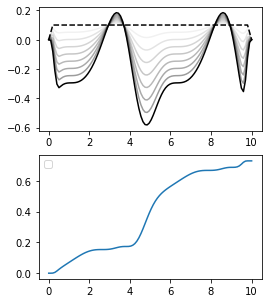

In [129]:
omega=1
ampl0=0.1
#T=8
mu=0.5
g=0.2*omega
#ampl0=1
T=10
nt=100
tlist = np.linspace(0,T, nt)
def hamiltonian(omega, ampl0, mu,g):
      """Two-level-system Hamiltonian

      Args:
          omega (float): energy separation of the qubit levels
          ampl0 (float): constant amplitude of the driving field
      """
      HA = qutip.Qobj(H0(g))
      H1 =qutip.Qobj(Hde(mu,g))
      H2= qutip.Qobj(He(mu))
      def guess_control(t, args):
          return ampl0*krotov.shapes.flattop(
              t, t_start=0, t_stop=T, t_rise=0.005, func="blackman"
          )
      def guess_control2(t, args):
          return ampl0*krotov.shapes.flattop(
              t, t_start=0, t_stop=T, t_rise=0.005, func="blackman"
          )
      
      return [HA, [H1, guess_control], [H2, guess_control]]
def S(t):
    """Shape function for the field update"""
    return krotov.shapes.flattop(
        t, t_start=0, t_stop=T, t_rise=0.05 * T, t_fall=0.05 * T, func='sinsq'
    )
def plot_iterations(opt_result):
    """Plot the control fields in population dynamics over all iterations.

    This depends on ``store_all_pulses=True`` in the call to
    `optimize_pulses`.
    """

    fig, [ax_ctr,ax] = plt.subplots(nrows=2, figsize=(4, 5))
    n_iters = len(opt_result.iters)
    EEnergy=np.zeros(nt)
    for (iteration, pulses) in zip(opt_result.iters, opt_result.all_pulses):
        controls = [
            krotov.conversions.pulse_onto_tlist(pulse)
            for pulse in pulses
        ]
        objectives = opt_result.objectives_with_controls(controls)
        dynamics = objectives[0].mesolve(
            opt_result.tlist, e_ops=[]
        )
        if iteration == 0:
            ls = '--'  # dashed
            alpha = 1  # full opacity
            ctr_label = 'guess'
            pop_labels = ['0 (guess)', '1 (guess)']
        elif iteration == opt_result.iters[-1]:
            ls = '-'  # solid
            alpha = 1  # full opacity
            ctr_label = 'optimized'
            pop_labels = ['0 (optimized)', '1 (optimized)']
        else:
            ls = '-'  # solid
            alpha = 0.5 * float(iteration) / float(n_iters)  # max 50%
            ctr_label = None
            pop_labels = [None, None]
        ax_ctr.plot(
            dynamics.times,
            controls[0],
            label=ctr_label,
            color='black',
            ls=ls,
            alpha=alpha,
        )
    EField=np.transpose(np.array(opt_result.optimized_controls))
    EEnergy[0]=(np.square(EField[0]))*(T/nt)
    a=0
    for i in range (1,nt):
      a+=np.square(EField[i-1])
      EEnergy[i]=(np.square(EField[i])+a)*(T/nt)
      
    
    ax.plot(tlist,np.transpose(EEnergy))
    plt.legend()
    plt.show(fig)
    
    
    



H = hamiltonian(omega,ampl0,mu,g)
pulse_options = {
    H[1][1]: dict(lambda_a=1, update_shape=S), 

    
}

r=np.pi/4
r2=np.pi/8
theta=np.pi/4
objectives = [
    krotov.Objective(
        #initial_state=qutip.Qobj(np.array([1,0,0,0,0,1/2*np.cosh(2*r2),0,-1/2*np.sinh(2*r2)*np.cos(theta),-1/2*np.sinh(2*r2)*np.sin(theta),1/2*np.cosh(2*r2),-1/2*np.sinh(2*r2)*np.sin(theta),1/2*np.sinh(2*r2)*np.cos(theta),1/2*np.cosh(2*r2),0,1/2*np.cosh(2*r2)])), target=qutip.Qobj(qutip.Qobj(np.array([1,0,0,0,0,1/2*np.cosh(2*r),0,-1/2*np.sinh(2*r)*np.cos(theta),-1/2*np.sinh(2*r)*np.sin(theta),1/2*np.cosh(2*r),-1/2*np.sinh(2*r)*np.sin(theta),1/2*np.sinh(2*r)*np.cos(theta),1/2*np.cosh(2*r),0,1/2*np.cosh(2*r)]))), H=H
        initial_state=qutip.Qobj(np.array([1,0,0,0,0,1/2,0,0,0,1/2,0,0,1/2,0,1/2])), target=qutip.Qobj(qutip.Qobj(np.array([1,np.sqrt(2), np.sqrt(2),np.sqrt(2),np.sqrt(2),1/2,0,0,0,1/2,0,0,1/2,0,1/2]))), H=H
      )
  ]

opt_result = krotov.optimize_pulses(
  objectives,
  pulse_options=pulse_options,
  tlist=tlist,
  fieldcoupling=mu,
  propagator=krotov.propagators.expm,
  chi_constructor=krotov.functionals.chis_ss,
  info_hook=krotov.info_hooks.print_table(J_T=krotov.functionals.J_T_ss),
  check_convergence=krotov.convergence.Or(
      krotov.convergence.value_below('9e-3', name='J_T'),
      krotov.convergence.check_monotonic_error,
      #krotov.convergence.check_monotonic_fidelity,

  ),
    store_all_pulses=True,
    overlap=inte.coherent_overlap,norm='gaussiano'
)
plot_iterations(opt_result)




In [128]:
opt_result

Krotov Optimization Result
--------------------------
- Started at 2022-01-24 18:03:56
- Number of objectives: 1
- Number of iterations: 1
- Reason for termination: Reached convergence: Loss of monotonic convergence; fidelity increase < 0
- Ended at 2022-01-24 18:03:59 (0:00:03)

iter.      J_T    ∫gₐ(t)dt          J       ΔJ_T         ΔJ  secs
0     9.91e-01    0.00e+00   9.91e-01        n/a        n/a     0
1     9.90e-01    2.61e-02   1.02e+00  -1.58e-03   2.45e-02     1 *


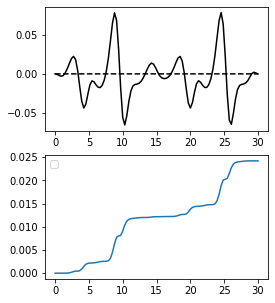

In [123]:
omega=1
ampl0=0.00001
#T=8
mu=0.5
g=0.2*omega
#ampl0=1
T=30
nt=100
tlist = np.linspace(0,T, nt)
def hamiltonian(omega, ampl0, mu,g):
      """Two-level-system Hamiltonian

      Args:
          omega (float): energy separation of the qubit levels
          ampl0 (float): constant amplitude of the driving field
      """
      HA = qutip.Qobj(H0(g))
      H1 =qutip.Qobj(Hde(mu,g))
      H2= qutip.Qobj(He(mu))
      def guess_control(t, args):
          return ampl0*krotov.shapes.flattop(
              t, t_start=0, t_stop=T, t_rise=0.005, func="blackman"
          )
      def guess_control2(t, args):
          return ampl0*krotov.shapes.flattop(
              t, t_start=0, t_stop=T, t_rise=0.005, func="blackman"
          )
      
      return [HA, [H1, guess_control], [H2, guess_control]]
def S(t):
    """Shape function for the field update"""
    return krotov.shapes.flattop(
        t, t_start=0, t_stop=T, t_rise=0.05 * T, t_fall=0.05 * T, func='sinsq'
    )
def plot_iterations(opt_result):
    """Plot the control fields in population dynamics over all iterations.

    This depends on ``store_all_pulses=True`` in the call to
    `optimize_pulses`.
    """

    fig, [ax_ctr,ax] = plt.subplots(nrows=2, figsize=(4, 5))
    n_iters = len(opt_result.iters)
    EEnergy=np.zeros(nt)
    for (iteration, pulses) in zip(opt_result.iters, opt_result.all_pulses):
        controls = [
            krotov.conversions.pulse_onto_tlist(pulse)
            for pulse in pulses
        ]
        objectives = opt_result.objectives_with_controls(controls)
        dynamics = objectives[0].mesolve(
            opt_result.tlist, e_ops=[]
        )
        if iteration == 0:
            ls = '--'  # dashed
            alpha = 1  # full opacity
            ctr_label = 'guess'
            pop_labels = ['0 (guess)', '1 (guess)']
        elif iteration == opt_result.iters[-1]:
            ls = '-'  # solid
            alpha = 1  # full opacity
            ctr_label = 'optimized'
            pop_labels = ['0 (optimized)', '1 (optimized)']
        else:
            ls = '-'  # solid
            alpha = 0.5 * float(iteration) / float(n_iters)  # max 50%
            ctr_label = None
            pop_labels = [None, None]
        ax_ctr.plot(
            dynamics.times,
            controls[0],
            label=ctr_label,
            color='black',
            ls=ls,
            alpha=alpha,
        )
    EField=np.transpose(np.array(opt_result.optimized_controls))
    EEnergy[0]=(np.square(EField[0]))*(T/nt)
    a=0
    for i in range (1,nt):
      a+=np.square(EField[i-1])
      EEnergy[i]=(np.square(EField[i])+a)*(T/nt)
      
    
    ax.plot(tlist,np.transpose(EEnergy))
    plt.legend()
    plt.show(fig)
    
    
    



H = hamiltonian(omega,ampl0,mu,g)
pulse_options = {
    H[1][1]: dict(lambda_a=1, update_shape=S), 

    
}

r=np.pi/4
r2=np.pi/8
theta=np.pi/4
objectives = [
    krotov.Objective(
        #initial_state=qutip.Qobj(np.array([1,0,0,0,0,1/2*np.cosh(2*r2),0,-1/2*np.sinh(2*r2)*np.cos(theta),-1/2*np.sinh(2*r2)*np.sin(theta),1/2*np.cosh(2*r2),-1/2*np.sinh(2*r2)*np.sin(theta),1/2*np.sinh(2*r2)*np.cos(theta),1/2*np.cosh(2*r2),0,1/2*np.cosh(2*r2)])), target=qutip.Qobj(qutip.Qobj(np.array([1,0,0,0,0,1/2*np.cosh(2*r),0,-1/2*np.sinh(2*r)*np.cos(theta),-1/2*np.sinh(2*r)*np.sin(theta),1/2*np.cosh(2*r),-1/2*np.sinh(2*r)*np.sin(theta),1/2*np.sinh(2*r)*np.cos(theta),1/2*np.cosh(2*r),0,1/2*np.cosh(2*r)]))), H=H
        initial_state=qutip.Qobj(np.array([1,0,0,0,0,1/2,0,0,0,1/2,0,0,1/2,0,1/2])), target=qutip.Qobj(qutip.Qobj(np.array([1,0.6*np.sqrt(2), 2*np.sqrt(2),-0.6*np.sqrt(2),0,1/2,0,0,0,1/2,0,0,1/2,0,1/2]))), H=H
      )
  ]

opt_result = krotov.optimize_pulses(
  objectives,
  pulse_options=pulse_options,
  tlist=tlist,
  fieldcoupling=mu,
  propagator=krotov.propagators.expm,
  chi_constructor=krotov.functionals.chis_ss,
  info_hook=krotov.info_hooks.print_table(J_T=krotov.functionals.J_T_ss),
  check_convergence=krotov.convergence.Or(
      krotov.convergence.value_below('9e-3', name='J_T'),
      #krotov.convergence.check_monotonic_error,
      krotov.convergence.check_monotonic_fidelity,

  ),
    store_all_pulses=True,
    overlap=inte.coherent_overlap,norm='gaussiano'
)
plot_iterations(opt_result)




iter.      J_T    ∫gₐ(t)dt          J       ΔJ_T         ΔJ  secs
0     9.97e-01    0.00e+00   9.97e-01        n/a        n/a     0
1     9.96e-01    1.62e-02   1.01e+00  -3.37e-04   1.58e-02     1 *
2     9.96e-01    1.62e-02   1.01e+00  -3.55e-04   1.58e-02     1 *
3     9.96e-01    1.62e-02   1.01e+00  -3.72e-04   1.58e-02     1 *
4     9.95e-01    1.62e-02   1.01e+00  -3.88e-04   1.58e-02     1 *
5     9.95e-01    1.62e-02   1.01e+00  -4.02e-04   1.58e-02     1 *
6     9.94e-01    1.62e-02   1.01e+00  -4.14e-04   1.58e-02     1 *
7     9.94e-01    1.62e-02   1.01e+00  -4.23e-04   1.57e-02     1 *
8     9.94e-01    1.62e-02   1.01e+00  -4.29e-04   1.57e-02     1 *
9     9.93e-01    1.62e-02   1.01e+00  -4.32e-04   1.57e-02     1 *
10    9.93e-01    1.62e-02   1.01e+00  -4.32e-04   1.57e-02     1 *
11    9.92e-01    1.62e-02   1.01e+00  -4.28e-04   1.57e-02     1 *
12    9.92e-01    1.62e-02   1.01e+00  -4.20e-04   1.58e-02     1 *
13    9.91e-01    1.62e-02   1.01e+00  -4.08e-04   1

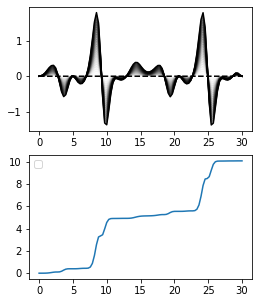

In [131]:
omega=1
ampl0=0.00001
#T=8
mu=0.5
g=0.2*omega
#ampl0=1
T=30
nt=100
tlist = np.linspace(0,T, nt)
def hamiltonian(omega, ampl0, mu,g):
      """Two-level-system Hamiltonian

      Args:
          omega (float): energy separation of the qubit levels
          ampl0 (float): constant amplitude of the driving field
      """
      HA = qutip.Qobj(H0(g))
      H1 =qutip.Qobj(Hde(mu,g))
      H2= qutip.Qobj(He(mu))
      def guess_control(t, args):
          return ampl0*krotov.shapes.flattop(
              t, t_start=0, t_stop=T, t_rise=0.005, func="blackman"
          )
      def guess_control2(t, args):
          return ampl0*krotov.shapes.flattop(
              t, t_start=0, t_stop=T, t_rise=0.005, func="blackman"
          )
      
      return [HA, [H1, guess_control], [H2, guess_control]]
def S(t):
    """Shape function for the field update"""
    return krotov.shapes.flattop(
        t, t_start=0, t_stop=T, t_rise=0.05 * T, t_fall=0.05 * T, func='sinsq'
    )
def plot_iterations(opt_result):
    """Plot the control fields in population dynamics over all iterations.

    This depends on ``store_all_pulses=True`` in the call to
    `optimize_pulses`.
    """

    fig, [ax_ctr,ax] = plt.subplots(nrows=2, figsize=(4, 5))
    n_iters = len(opt_result.iters)
    EEnergy=np.zeros(nt)
    for (iteration, pulses) in zip(opt_result.iters, opt_result.all_pulses):
        controls = [
            krotov.conversions.pulse_onto_tlist(pulse)
            for pulse in pulses
        ]
        objectives = opt_result.objectives_with_controls(controls)
        dynamics = objectives[0].mesolve(
            opt_result.tlist, e_ops=[]
        )
        if iteration == 0:
            ls = '--'  # dashed
            alpha = 1  # full opacity
            ctr_label = 'guess'
            pop_labels = ['0 (guess)', '1 (guess)']
        elif iteration == opt_result.iters[-1]:
            ls = '-'  # solid
            alpha = 1  # full opacity
            ctr_label = 'optimized'
            pop_labels = ['0 (optimized)', '1 (optimized)']
        else:
            ls = '-'  # solid
            alpha = 0.5 * float(iteration) / float(n_iters)  # max 50%
            ctr_label = None
            pop_labels = [None, None]
        ax_ctr.plot(
            dynamics.times,
            controls[0],
            label=ctr_label,
            color='black',
            ls=ls,
            alpha=alpha,
        )
    EField=np.transpose(np.array(opt_result.optimized_controls))
    EEnergy[0]=(np.square(EField[0]))*(T/nt)
    a=0
    for i in range (1,nt):
      a+=np.square(EField[i-1])
      EEnergy[i]=(np.square(EField[i])+a)*(T/nt)
      
    
    ax.plot(tlist,np.transpose(EEnergy))
    plt.legend()
    plt.show(fig)
    
    
    



H = hamiltonian(omega,ampl0,mu,g)
pulse_options = {
    H[1][1]: dict(lambda_a=1, update_shape=S), 

    
}

r=np.pi/4
r2=np.pi/8
theta=np.pi/4
objectives = [
    krotov.Objective(
        #initial_state=qutip.Qobj(np.array([1,0,0,0,0,1/2*np.cosh(2*r2),0,-1/2*np.sinh(2*r2)*np.cos(theta),-1/2*np.sinh(2*r2)*np.sin(theta),1/2*np.cosh(2*r2),-1/2*np.sinh(2*r2)*np.sin(theta),1/2*np.sinh(2*r2)*np.cos(theta),1/2*np.cosh(2*r2),0,1/2*np.cosh(2*r2)])), target=qutip.Qobj(qutip.Qobj(np.array([1,0,0,0,0,1/2*np.cosh(2*r),0,-1/2*np.sinh(2*r)*np.cos(theta),-1/2*np.sinh(2*r)*np.sin(theta),1/2*np.cosh(2*r),-1/2*np.sinh(2*r)*np.sin(theta),1/2*np.sinh(2*r)*np.cos(theta),1/2*np.cosh(2*r),0,1/2*np.cosh(2*r)]))), H=H
        initial_state=qutip.Qobj(np.array([1,0,0,0,0,1/2,0,0,0,1/2,0,0,1/2,0,1/2])), target=qutip.Qobj(qutip.Qobj(np.array([1,0.6*np.sqrt(2), 2*np.sqrt(2),-0.6*np.sqrt(2),np.sqrt(2),1/2,0,0,0,1/2,0,0,1/2,0,1/2]))), H=H
      )
  ]

opt_result = krotov.optimize_pulses(
  objectives,
  pulse_options=pulse_options,
  tlist=tlist,
  fieldcoupling=mu,
  propagator=krotov.propagators.expm,
  chi_constructor=krotov.functionals.chis_ss,
  info_hook=krotov.info_hooks.print_table(J_T=krotov.functionals.J_T_ss),
  check_convergence=krotov.convergence.Or(
      krotov.convergence.value_below('9e-3', name='J_T'),
      krotov.convergence.check_monotonic_error,
      #krotov.convergence.check_monotonic_fidelity,

  ),
    store_all_pulses=True,
    overlap=inte.coherent_overlap,norm='gaussiano'
)
plot_iterations(opt_result)




In [124]:
opt_result

Krotov Optimization Result
--------------------------
- Started at 2022-01-24 18:01:59
- Number of objectives: 1
- Number of iterations: 1
- Reason for termination: Reached convergence: Loss of monotonic convergence; fidelity increase < 0
- Ended at 2022-01-24 18:02:01 (0:00:02)

Function to get the states at each t for optimized field

In [110]:
from scipy.integrate import simpson


def field_discrete(lista,t,dt):
    return lista[int(t/dt)]

def states(psi0,g,mu):
    HA = qutip.Qobj(H0(g))
    H1 =qutip.Qobj(Hde(mu,g))
    H2=qutip.Qobj(He(mu))
    states=np.zeros((len(opt_result.tlist),15),dtype=complex)
    integral=np.zeros(nt)

    for time_index in range(len(opt_result.tlist)-1):
        if time_index==0:
            integral[time_index]=0
        else:    
            integral[time_index]=simpson(np.array(opt_result.optimized_controls[0])[:time_index], np.array(opt_result.tlist)[:time_index])
    
    dt=opt_result.tlist[1]-opt_result.tlist[0]
    for i in range (0,len(opt_result.tlist)):
        #A=HA+H1*field_discrete(opt_result.optimized_controls[0],opt_result.tlist[i],dt)+H2*field_discrete(integral,opt_result.tlist[i],dt)
        A=HA+H1*opt_result.optimized_controls[0][i]+H2*integral[i]
        '''if i==len(opt_result.tlist)-1:
            A=HA+H2*opt_result.optimized_controls[0][i]+H1*(opt_result.optimized_controls[0][i]-opt_result.optimized_controls[0][i-1])/dt
        else:
            
            A=HA+H2*opt_result.optimized_controls[0][i]+H1*(opt_result.optimized_controls[0][i+1]-opt_result.optimized_controls[0][i])/dt'''
        if i==1:
            states[i,:]=(((-A * dt).expm())(psi0)).trans()
        elif i==0:
            states[i,:]=psi0.trans()
        else:
            states[i][:]=((-A * dt).expm())(qutip.Qobj(states[i-1][:])).trans()

    return states

Plot in phase space the last state and the target for the battery

C:\Users\ricar\anaconda3\lib\site-packages\numpy\ma\core.py:2825: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _data = np.array(data, dtype=dtype, copy=copy,


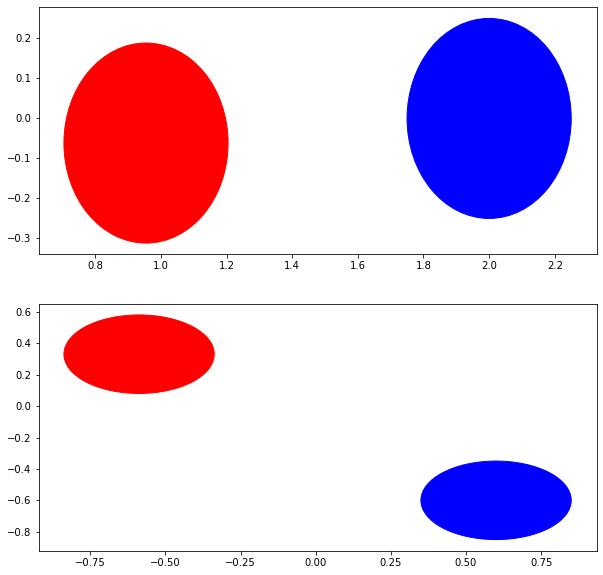

In [132]:
target=np.array([1,0.6*np.sqrt(2), 2*np.sqrt(2),-0.6*np.sqrt(2),0,1/2,0,0,0,1/2,0,0,1/2,0,1/2])

circle1=plt.Circle((1/np.sqrt(2)*np.real(opt_result.states[0][2]), 1/np.sqrt(2)*np.real(opt_result.states[0][4])), 0.25, color='r')
circle2=plt.Circle((1/np.sqrt(2)*target[2], 1/np.sqrt(2)*target[4]), 0.25, color='b')

fig, ax = plt.subplots(2,figsize=(10,10)) 

x=[1/np.sqrt(2)*np.real(opt_result.states[0][2]),1/np.sqrt(2)*target[2]]
y=[1/np.sqrt(2)*np.real(opt_result.states[0][4]),1/np.sqrt(2)*target[4]]



ax[0].scatter(x,y)
ax[0].add_patch(circle1)
ax[0].add_patch(circle2)



x=[1/np.sqrt(2)*np.real(opt_result.states[0][1]),1/np.sqrt(2)*target[1]]
y=[1/np.sqrt(2)*np.real(opt_result.states[0][3]),1/np.sqrt(2)*target[3]]



circle3=plt.Circle((1/np.sqrt(2)*np.real(opt_result.states[0][1]), 1/np.sqrt(2)*np.real(opt_result.states[0][3])), 0.25, color='r')
circle4=plt.Circle((1/np.sqrt(2)*target[1], 1/np.sqrt(2)*target[3]), 0.25, color='b')

ax[1].scatter(x,y)
ax[1].add_patch(circle3)
ax[1].add_patch(circle4)

plt.show()

In [94]:
1-np.abs(inte.coherent_overlap(opt_result.states[0],qutip.Qobj(target)))**2

0.9706997877916896

In [118]:
opt_result

Krotov Optimization Result
--------------------------
- Started at 2022-01-24 17:18:42
- Number of objectives: 1
- Number of iterations: 3
- Reason for termination: Reached convergence: Loss of monotonic convergence; error decrease < 0
- Ended at 2022-01-24 17:18:51 (0:00:09)

Function to get the real field

In [6]:
def field():
    integral=np.zeros(nt)
    for time_index in range(len(opt_result.tlist)):
        if time_index==0:
            integral[time_index]=0
        else:    
            integral[time_index]=simpson(np.array(opt_result.optimized_controls[0])[:time_index], np.array(opt_result.tlist)[:time_index])
        
    return integral

Energy vs time

array([0.70710678+0.j, 1.61657113+0.j, 1.01709977+0.j, 0.48989671+0.j,
       0.33455672+0.j, 0.35355339+0.j, 0.        +0.j, 0.        +0.j,
       0.        +0.j, 0.35355339+0.j, 0.        +0.j, 0.        +0.j,
       0.35355339+0.j, 0.        +0.j, 0.35355339+0.j])

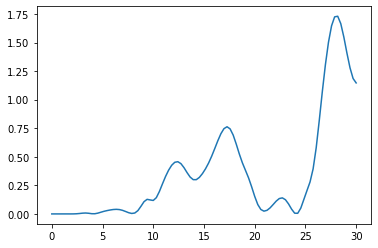

In [108]:
psi0=qutip.Qobj(np.array([1,0,0,0,0,1/2,0,0,0,1/2,0,0,1/2,0,1/2]))
psi=states(psi0,g,mu)
Energy=np.zeros(nt)
for i in range (0,np.shape(psi)[0]):
    Energy[i]=1/2*(np.real(psi[i][9])+(np.real(psi[i][2]))**2+np.real(psi[i][14])+(np.real(psi[i][4]))**2)-1/2
plt.plot(opt_result.tlist,Energy)

psi[nt-1]/np.sqrt(2)

In [6]:
for i in range (0,nt):
    print(psi[i][9]*psi[i][14])
    print(psi[i][5]*psi[i][12])

(0.25+0j)
(0.25+0j)
(0.20146742857119704+0j)
(0.3801538652666529+0j)
(0.38903770122180825+0j)
(0.18708025026969077+0j)
(0.22611051998567272+0j)
(0.276436244067842+0j)
(0.22053085508855214+0j)
(0.36422264310737584+0j)
(0.3900696924888927+0j)
(0.17778181707253385+0j)
(0.2059456973411258+0j)
(0.3038655184096872+0j)
(0.2435593822906608+0j)
(0.3426465335563116+0j)
(0.38315538539100363+0j)
(0.1737753853175901+0j)
(0.1903061446322379+0j)
(0.33043594744314403+0j)


Electric field

-3.1795386314542387


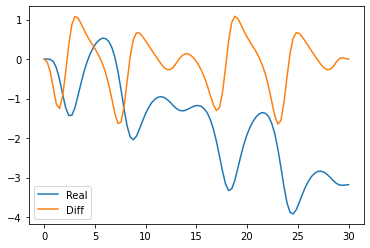

In [7]:
Efield=field()
plt.plot(opt_result.tlist,Efield,label="Real")
plt.plot(opt_result.tlist,opt_result.optimized_controls[0],label="Diff")
plt.legend()
print(Efield[nt-1])

In [114]:
for i in range(0,15):
    print(opt_result.states[0][i]-psi[nt-1][i])

[[0.+0.j]]
[[-0.12000581+0.j]]
[[-0.09377197+0.j]]
[[0.05249042+0.j]]
[[0.28985337+0.j]]
[[-1.77635684e-15+0.j]]
[[0.+0.j]]
[[0.+0.j]]
[[0.+0.j]]
[[6.10622664e-15+0.j]]
[[0.+0.j]]
[[0.+0.j]]
[[-1.88737914e-15+0.j]]
[[0.+0.j]]
[[5.55111512e-15+0.j]]


In [81]:
opt_result.states

[Quantum object: dims = [[15], [1]], shape = (15, 1), type = ket
 Qobj data =
 [[1.        ]
  [2.166171  ]
  [1.34462431]
  [0.745309  ]
  [0.76298802]
  [0.5       ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.5       ]
  [0.        ]
  [0.        ]
  [0.5       ]
  [0.        ]
  [0.5       ]]]

In [90]:
qutip.Qobj(target)

Quantum object: dims = [[15], [1]], shape = (15, 1), type = ket
Qobj data =
[[ 1.        ]
 [ 0.84852814]
 [ 2.82842712]
 [-0.84852814]
 [ 0.        ]
 [ 0.5       ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.5       ]
 [ 0.        ]
 [ 0.        ]
 [ 0.5       ]
 [ 0.        ]
 [ 0.5       ]]

In [46]:
optimized_dynamics = opt_result.optimized_objectives[0].essolve(
      tlist, e_ops=[]
  )
optimized_dynamics.states[0]

AttributeError: 'Objective' object has no attribute 'essolve'

In [22]:
opt_result.optimized_controls

[array([-1.38777878e-25, -4.05338078e-02, -8.06291106e-02, -7.98867479e-02,
        -7.94169483e-02, -7.91997330e-02, -7.91718587e-02, -7.92517354e-02,
        -7.93706327e-02, -7.94998530e-02, -7.96629298e-02, -7.99254245e-02,
        -8.03640445e-02, -8.10276400e-02, -8.19082271e-02, -8.29360929e-02,
        -8.40003544e-02, -8.49819578e-02, -4.27188862e-02, -1.38777878e-25])]

In [29]:
from scipy.integrate import simpson
integral=np.zeros(nt)

for time_index in range(len(opt_result.tlist) - 1):
    if time_index==0:
        integral[time_index]=0
    else:    
        integral[time_index]=simpson(np.array(opt_result.optimized_controls[0])[:time_index], np.array(opt_result.tlist)[:time_index])

In [55]:
def field_discrete2(t,args):
    return integral[int(t/dt)]

def field_discrete(t,args):
    return opt_result.optimized_controls[0][int(t/dt)]
T=4
nt=20
dt=opt_result.tlist[1]-opt_result.tlist[0]
HA =-1j* qutip.Qobj(H0(0.2))
H1 =-1j*qutip.Qobj(Hde(0.05,0.2))
H2= -1j*qutip.Qobj(He(0.05,0.2))
H=[HA,[H1,field_discrete],[H2,field_discrete2]]
psi0=qutip.Qobj(np.array([1,0,0,0,0,1/2,0,0,0,1/2,0,0,1/2,0,1/2]))


In [58]:
output = qutip.mesolve(H, psi0, opt_result.tlist)

In [81]:
print((((-1j*H * dt).expm())(psi0)).trans())

Quantum object: dims = [[1], [15]], shape = (1, 15), type = bra
Qobj data =
[[ 1.          0.          0.          0.          0.          0.54266889
  -0.00873926  0.          0.          0.46082681  0.          0.
   0.54266889 -0.00873926  0.46082681]]


In [52]:
output.states[0]

Quantum object: dims = [[15], [1]], shape = (15, 1), type = ket
Qobj data =
[[0.70710678]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.35355339]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.35355339]
 [0.        ]
 [0.        ]
 [0.35355339]
 [0.        ]
 [0.35355339]]

In [53]:
psi0

Quantum object: dims = [[15], [1]], shape = (15, 1), type = ket
Qobj data =
[[1. ]
 [0. ]
 [0. ]
 [0. ]
 [0. ]
 [0.5]
 [0. ]
 [0. ]
 [0. ]
 [0.5]
 [0. ]
 [0. ]
 [0.5]
 [0. ]
 [0.5]]

In [4]:
from src.krotov.second_order import _overlap

In [ ]:
def plot_pulse(pulse, tlist):
    fig, ax = plt.subplots()
    if callable(pulse):
        pulse = np.array([pulse(t, args=None) for t in tlist])
    ax.plot(tlist, pulse)
    ax.set_xlabel('Time')
    ax.set_ylabel('Pulse Amplitude')
    plt.show(fig)

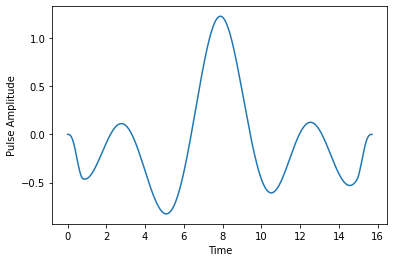

In [ ]:
plot_pulse(opt_result.optimized_controls[0], tlist)

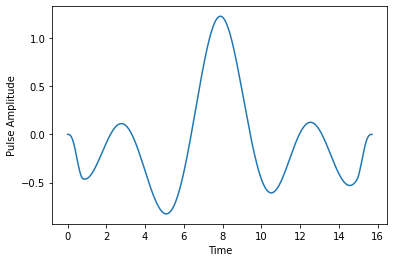

In [ ]:
plot_pulse(opt_result.optimized_controls[0], tlist)

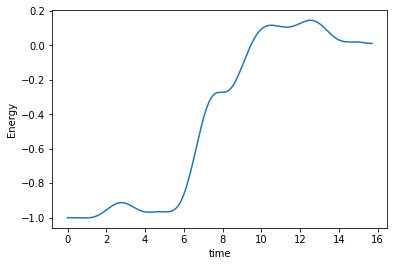

In [ ]:
Energy=np.zeros(nt)
optimized_dynamics = opt_result.optimized_objectives[0].mesolve(
      tlist, e_ops=[]
  )
for i in range(0,nt):
  H = hamiltonian(omega,ampl0,g)[0]+hamiltonian(omega,ampl0,g)[1][0]*opt_result.optimized_controls[0][i]
  rho=optimized_dynamics.states[i]*optimized_dynamics.states[i].dag()
  Energy[i]=np.real(np.matrix.trace(np.array(rho*H)))

plt.plot(tlist,Energy)
plt.xlabel("time")
plt.ylabel("Energy")
plt.show()

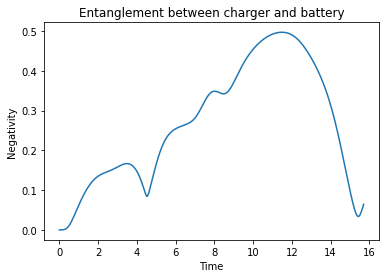

Negativity at final time T:  0.0644747582456493


In [ ]:
optimized_dynamics = opt_result.optimized_objectives[0].mesolve(
      tlist, e_ops=[]
  )

figen, ent = plt.subplots()
Negativity=np.zeros(nt)

for i in range(0,nt):
  PartialTranspose=qutip.partial_transpose(optimized_dynamics.states[i]*optimized_dynamics.states[i].dag(),[1,0])
  P=np.real(np.trace(np.sqrt(np.array(PartialTranspose.dag()*PartialTranspose))))
  Negativity[i]=(P-1)/2

ent.plot(tlist,Negativity)
ent.set_xlabel("Time")
ent.set_ylabel("Negativity")
ent.set_title("Entanglement between charger and battery")
plt.show(figen)
print("Negativity at final time T: ", Negativity[nt-1])


In [ ]:
def trace_A(rho):
    """Partial trace over the A degrees of freedom"""
    rho_q = np.zeros(shape=(2, 2), dtype=np.complex_)
    rho_q[0, 0] = rho[0, 0] + rho[2, 2]
    rho_q[0, 1] = rho[0, 1] + rho[2, 3]
    rho_q[1, 0] = rho[1, 0] + rho[3, 2]
    rho_q[1, 1] = rho[1, 1] + rho[3, 3]
    return qutip.Qobj(rho_q)

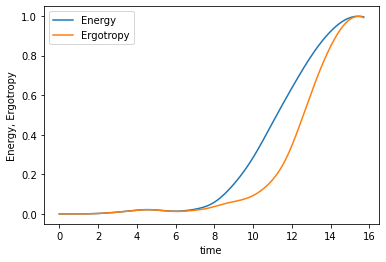

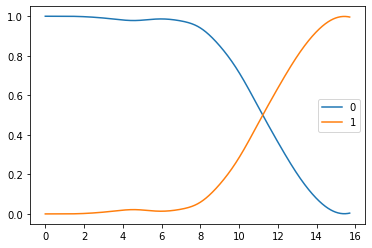

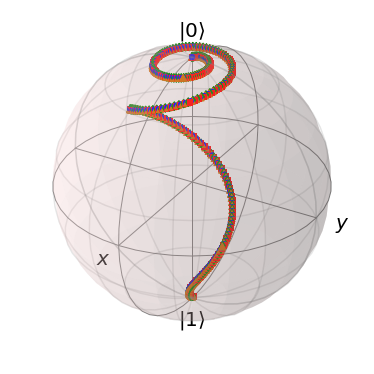

In [ ]:
from numpy import linalg as npla

def eigenvalues(A):
    eigenValues, eigenVectors = npla.eig(A)
    idx = np.argsort(eigenValues)
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]
    return (eigenValues)

optimized_dynamics = opt_result.optimized_objectives[0].mesolve(
      tlist, e_ops=[]
  )
Ergotropy=np.zeros(nt)
Energy=np.zeros(nt)
matrix=np.zeros(nt)

b = qutip.Bloch()

for i in range(0,nt):
  FinalRho=trace_A(np.array(optimized_dynamics.states[i]*optimized_dynamics.states[i].dag()))
  matrix[i]=np.real(FinalRho[0,0])
  point1=[2*np.real(FinalRho[0,1]), -2*np.imag(FinalRho[0,1]), FinalRho[0,0] -FinalRho[1,1]]
  b.add_points(point1)
  Rho_f=eigenvalues(FinalRho)[1]*np.array([[1, 0], [0, 0]])+eigenvalues(FinalRho)[0]*np.array([[0, 0], [0, 1]])
  Energy[i]=np.real(np.matrix.trace(omega*np.dot(np.array([[0, 0], [0, 1]]),FinalRho)))
  Ergotropy[i]=-np.real(np.matrix.trace(omega*np.dot(np.array([[0, 0], [0, 1]]),(Rho_f-FinalRho))))
 


plt.plot(tlist,Energy,label='Energy')
plt.plot(tlist,Ergotropy,label='Ergotropy')
plt.xlabel("time")
plt.ylabel("Energy, Ergotropy")
plt.legend() 
plt.figure()
plt.plot(tlist,matrix,label="0")
plt.plot(tlist,Energy,label="1")
plt.legend() 
plt.show()
b.render()

In [ ]:
optimized_dynamics = opt_result.optimized_objectives[0].mesolve(
      tlist, e_ops=[]
  )


HA =  omega * qutip.tensor(0.5*(-qutip.operators.sigmaz()),qutip.qeye(2))
HB =  omega* qutip.tensor(qutip.qeye(2),0.5*(-qutip.operators.sigmaz()))
HAB = g*(qutip.tensor(qutip.destroy(2),qutip.create(2))+qutip.tensor(qutip.create(2),qutip.destroy(2)))
H0 = HA+HB+HAB
H=np.array(H0)
print(H)
Uncert=np.dot(np.dot(np.array(optimized_dynamics.states[0].dag()),H**2),np.array(optimized_dynamics.states[0]))-(np.dot(np.dot(np.array(optimized_dynamics.states[0].dag()),H),np.array(optimized_dynamics.states[0])))**2
F=np.dot(np.array(optimized_dynamics.states[0].dag()),np.array(optimized_dynamics.states[nt-1]))
print(Uncert)
TQSL=1/Uncert*np.arccos(np.abs(F))
print(TQSL)

print(T-TQSL)

[[-1. +0.j  0. +0.j  0. +0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  0.2+0.j  0. +0.j]
 [ 0. +0.j  0.2+0.j  0. +0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j  1. +0.j]]
[[0.+0.j]]
[[nan+nanj]]
[[nan+nanj]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in multiply
  from ipykernel import kernelapp as app


In [ ]:
optimized_dynamics = opt_result.optimized_objectives[0].mesolve(
      tlist, e_ops=[]
  )

Q=0
Q2=0
HA =  omega * qutip.tensor(0.5*(-qutip.operators.sigmaz()+qutip.qeye(2)),qutip.qeye(2))
HB =  omega* qutip.tensor(qutip.qeye(2),0.5*(-qutip.operators.sigmaz()+qutip.qeye(2)))
HAB = g*(qutip.tensor(qutip.destroy(2),qutip.create(2))+qutip.tensor(qutip.create(2),qutip.destroy(2)))
H0 = HA+HB+HAB

for i in range (0,nt):
  H1 = -qutip.tensor(0.5*qutip.operators.sigmax(),qutip.qeye(2))*opt_result.optimized_controls[0][i]
  H=H0+H1
  L=qutip.liouvillian(H)
  rho=optimized_dynamics.states[i]*optimized_dynamics.states[i].dag()
  ket=optimized_dynamics.states[i]
  Q += 1/(nt-1)*np.sqrt((2*np.trace(np.array(rho**2*H**2-(rho*H)**2)))/((np.trace(np.array(rho*rho-(qutip.tensor(qutip.qeye(2),qutip.qeye(2)))/16)))))
  Q2 += 1/(nt-1)*np.sqrt(np.trace(np.array(L(rho).dag()*L(rho))))

rho0=optimized_dynamics.states[0]*optimized_dynamics.states[0].dag()
rhoi=np.array(rho0)
vrho0=[2*np.real(rhoi[0][1]),-2*np.imag(rhoi[0][1]),np.real(rhoi[0][0]-rhoi[1][1])]
rhof=optimized_dynamics.states[nt-1]*optimized_dynamics.states[nt-1].dag()
rhof=np.array(rhof)
vrhof=[2*np.real(rhof[0][1]),-2*np.imag(rhof[0][1]),np.real(rhof[0][0]-rhof[1][1])]
#Phi=np.arccos(np.sqrt((np.array(np.trace(rho0*rhof)))/(np.trace(np.array(rho0*rho0)))))
Phi=np.arccos(np.dot(vrho0,vrhof))
#Fid=np.sqrt(np.trace(np.array((rho0-rhof)**2)))
Tf=Phi/Q 
#Tf2=Fid/Q2
print(T)
print(Tf)
print(T-Tf)


15.707963267948966
(4.751358632938551-9.3259923157834e-13j)
(10.956604635010414+9.3259923157834e-13j)


In [ ]:
print(rho)
print(qutip.qeye(4))

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 1.18640953e-04+0.00000000e+00j -1.04913022e-02+2.83641088e-03j
  -4.67573874e-04-4.93949242e-04j -2.21235216e-04-5.16912043e-05j]
 [-1.04913022e-02-2.83641088e-03j  9.95547036e-01+0.00000000e+00j
   2.95379945e-02+5.48579749e-02j  1.83278031e-02+9.86018735e-03j]
 [-4.67573874e-04+4.93949242e-04j  2.95379945e-02-5.48579749e-02j
   3.89925376e-03+0.00000000e+00j  1.08711735e-03-7.17370426e-04j]
 [-2.21235216e-04+5.16912043e-05j  1.83278031e-02-9.86018735e-03j
   1.08711735e-03+7.17370426e-04j  4.35069007e-04+0.00000000e+00j]]
Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


In [ ]:
    """Two-level-system Hamiltonian

      Args:
          omega (float): energy separation of the qubit levels
          ampl0 (float): constant amplitude of the driving field
      """
optimized_dynamics = opt_result.optimized_objectives[0].mesolve(
      tlist, e_ops=[]
  )

L0 = qutip.liouvillian(H=H0)
rhof=optimized_dynamics.states[nt-1]*optimized_dynamics.states[nt-1].dag()
rhoi=optimized_dynamics.states[0]*optimized_dynamics.states[0].dag()
rhodif= np.array(rhoi-rhof)
fid= np.sqrt(np.trace(np.dot(rhodif,rhodif)))
integral=0
for i in range(0,nt):
  H1 = -qutip.tensor(0.5*qutip.operators.sigmax(),qutip.qeye(2))*opt_result.optimized_controls[0][i]
  L1 = qutip.liouvillian(H=H1)
  L = L0 + L1
  rhot= L(optimized_dynamics.states[i]*optimized_dynamics.states[i].dag())
  integral += (1/(nt-1))*np.sqrt(np.trace(np.array(rhot.dag()*rhot)))


print("T = ", T)
print("T_QSL = ", np.real(fid/integral))
print("T - T_QSL = ", T-np.real(fid/integral))

T =  15.707963267948966
T_QSL =  2.5471565171549493
T - T_QSL =  13.160806750794016


In [ ]:
for i in range (0,nt):
  rho=np.array(optimized_dynamics.states[i]*optimized_dynamics.states[i].dag())
  print(rho[0][1])

0j
(-1.6292537578847838e-10+0j)
(-1.8424078411623442e-09-2.2679248793967603e-11j)
(-9.62253633974947e-09-1.7393975653516126e-10j)
(-3.3289549228878785e-08-7.835558911159285e-10j)
(-8.988413083670582e-08-2.596694621213651e-09j)
(-2.0547937635431234e-07-7.031868146840092e-09j)
(-4.170185570446097e-07-1.6495013478311413e-08j)
(-7.739150846866633e-07-3.474711067421242e-08j)
(-1.339522297686906e-06-6.73207203794757e-08j)
(-2.192442082044762e-06-1.2198062333699557e-07j)
(-3.427659720997291e-06-2.092234608582505e-07j)
(-5.157494652953913e-06-3.4281093541020153e-07j)
(-7.512358943192897e-06-5.403306217817139e-07j)
(-1.0641315720671715e-05-8.237784013816868e-07j)
(-1.4712431568002008e-05-1.2201562524094946e-06j)
(-1.991291869478411e-05-1.7620789723926794e-06j)
(-2.6449064266616948e-05-2.488383308088214e-06j)
(-3.4545945931334966e-05-3.444732904942514e-06j)
(-4.444693427796764e-05-4.684212476530974e-06j)
(-5.6412984642639716e-05-6.267904630769199e-06j)
(-7.072172228460695e-05-8.265442905919293e-

In [ ]:
from abc import ABC, abstractmethod

import numpy as np
import qutip
import scipy
from qutip.cy.spconvert import dense2D_to_fastcsr_fmode
from qutip.cy.spmatfuncs import spmvpy_csr
from qutip.superoperator import mat2vec, vec2mat


__all__ = ['expm', 'Propagator', 'DensityMatrixODEPropagator']


def expm(H, state, dt, c_ops=None, backwards=False, initialize=False):
    """Propagate using matrix exponentiation

    This supports `H` being a Hamiltonian (for a Hilbert space `state`) or a
    Liouvillian (for `state` being a density matrix) in nested-list format.
    Collapse operators `c_ops` are not supported. The propagator is not
    stateful, thus `initialize` is ignored.
    """
    if c_ops is None:
        c_ops = []
    if len(c_ops) > 0:
        raise NotImplementedError("Liouville exponentiation not implemented")
    assert isinstance(H, list) and len(H) > 0
    eqm_factor = -1j  # factor in front of H on rhs of the equation of motion
    if isinstance(H[0], list):
        if H[0][1].type == 'super':
            eqm_factor = 1
        if backwards:
            eqm_factor = eqm_factor.conjugate()
        A = (eqm_factor * H[0][1]) * H[0][0]
    else:
        if H[0].type == 'super':
            eqm_factor = 1
        if backwards:
            eqm_factor = eqm_factor.conjugate()
        A = eqm_factor * H[0]
    for part in H[1:]:
        if isinstance(part, list):
            A += (eqm_factor * part[1]) * part[0]
        else:
            A += eqm_factor * part
    ok_types = (state.type == 'oper' and A.type == 'super') or (
        state.type in ['ket', 'bra'] and A.type == 'oper'
    )
    if ok_types:
        return ((A * dt).expm())(state)
    else:
        raise NotImplementedError(
            "Cannot handle argument types A:%s, state:%s"
            % (A.type, state.type)
        )

omega=1
g=0.2*omega
ampl0=0.0000001+0j
#T=8
#ampl0=1
T=np.pi/g
nt=1000
tlist = np.linspace(0,T, nt)
def hamiltonian(omega, ampl0, g):
      """Two-level-system Hamiltonian

      Args:
          omega (float): energy separation of the qubit levels
          ampl0 (float): constant amplitude of the driving field
      """
      HA =  omega * qutip.tensor(0.5*(-qutip.operators.sigmaz()),qutip.qeye(2))
      HB =  omega* qutip.tensor(qutip.qeye(2),0.5*(-qutip.operators.sigmaz()))
      HAB = g*(qutip.tensor(qutip.destroy(2),qutip.create(2))+qutip.tensor(qutip.create(2),qutip.destroy(2)))
      H0 = HA+HB+HAB
      H1 = -qutip.tensor(0.5*qutip.operators.sigmax(),qutip.qeye(2))

      def guess_control(t, args):
          return ampl0 *krotov.shapes.flattop(
              t, t_start=0, t_stop=T, t_rise=0.005, func="blackman"
          )

      return [H0, [H1, 5]]


In [ ]:
expm(hamiltonian(omega,ampl0,g), qutip.tensor(qutip.ket("0"),qutip.ket("0")), T/(nt-1), c_ops=None, backwards=False, initialize=False)

In [ ]:
hamiltonian(omega,ampl0,g)[0]

In [ ]:
print(qutip.Qobj(np.eye(4)))

In [17]:
hamiltonian(2,5,2)

[Quantum object: dims = [[15], [15]], shape = (15, 15), type = oper, isherm = False
 Qobj data =
 [[1.08602416 0.66188681 0.72619927 1.00578677 0.68932275 0.92552788
   0.2386143  1.03783133 0.61781952 0.39161298 0.29693057 0.43031324
   0.64291148 1.0222388  0.81887365]
  [0.68195557 1.04969734 0.63520289 0.51962827 1.21935838 0.5130396
   0.79163522 0.63625899 0.92690289 0.85781388 0.48403956 0.33399188
   0.98427252 0.84438374 0.85064083]
  [0.61157802 0.33475476 0.37388666 0.84081808 1.10856581 0.47831971
   1.00682191 0.34717629 0.60543233 0.65481942 1.05724774 0.26455307
   0.72735198 0.18117238 1.06072897]
  [0.89090758 0.93398004 0.3043761  0.68101732 0.90180298 1.21058536
   0.52856323 0.86460814 0.6756025  0.88282619 0.64379104 0.51927658
   1.19233829 1.03885842 0.78206972]
  [0.68585134 0.94191225 0.99063674 0.80868482 0.82538403 1.08362736
   0.40036743 0.60749074 0.60954809 0.86178055 0.63151593 0.8549435
   0.68621851 0.71116363 0.85228259]
  [0.68983196 0.57587862 1.009

In [45]:
qutip.Qobj(np.array([0]+[5]*2))

Quantum object: dims = [[3], [1]], shape = (3, 1), type = ket
Qobj data =
[[0.]
 [5.]
 [5.]]

In [5]:
[0]*5 <2

TypeError: '<' not supported between instances of 'list' and 'int'

In [31]:
qutip.Qobj(np.array([1]*15))[3,0]

(1+0j)

In [7]:
F=qutip.Qobj(np.array([ 1.-1.56765159e-06j,-1.41421356+2.21699413e-06, 0.+0.00000000e+00j, 0.+0.00000000e+00j, 0.+0.00000000e+00j,-0.5+7.83825799e-07j,
 0.+0.00000000e+00j,0.+0.00000000e+00j,0.+0.00000000e+00j,-0.5+7.83825794e-07j,0.+0.00000000e+00j,0.+0.00000000e+00j,0.5-7.83825766e-07j,0.+0.00000000e+00j,
 0.5-7.83825801e-07j]))

In [8]:
F

Quantum object: dims = [[15], [1]], shape = (15, 1), type = ket
Qobj data =
[[ 1.        -1.56765159e-06j]
 [-1.41421134+0.00000000e+00j]
 [ 0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j]
 [-0.5       +7.83825799e-07j]
 [ 0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j]
 [-0.5       +7.83825794e-07j]
 [ 0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j]
 [ 0.5       -7.83825766e-07j]
 [ 0.        +0.00000000e+00j]
 [ 0.5       -7.83825801e-07j]]

In [9]:
W=qutip.Qobj(np.array([1,np.sqrt(2),0,0,0,1/2,0,0,0,1/2,0,0,1/2,0,1/2]))

In [10]:
inte.overlap2(F,W)

Integral in $\alpha_{4}$  is divergent, integrand does not fulfill $Re(C_{44})<0$

NameError: None

In [26]:
start=0
step=0.5
num=5

result=np.arange(0,num)*step+start

result

array([0. , 0.5, 1. , 1.5, 2. ])

In [27]:
suma=0
for time_index in range(len(result) - 1):
    for i in result:
        if result[time_index]>=i:
            suma+=0.5
            print(suma,i,time_index)
suma

0.5 0.0 0
1.0 0.0 1
1.5 0.5 1
2.0 0.0 2
2.5 0.5 2
3.0 1.0 2
3.5 0.0 3
4.0 0.5 3
4.5 1.0 3
5.0 1.5 3


5.0

In [7]:
_nested_list_shallow_copy(['Ha',['Hb']])

NameError: name '_nested_list_shallow_copy' is not defined

In [4]:
def suma(a,b,c=12):
    return a+b+c

In [6]:
suma(1,2,1)

4

In [6]:
def f1(x):
   return x**2

def f2(x):
   return x**3

x = np.array([1,3,4])
y1 = f1(x)
from scipy.integrate import simpson
I1 = simpson(y1[:2], x[:2])
print(I1)

10.0


In [6]:
x

array([1, 3, 4])

In [8]:
y1

array([ 1,  9, 16])

In [6]:
z=[np.array([-1.38777878e-25,  1.00000000e-08,  1.00000000e-08,  1.00000000e-08,
        1.00000000e-08,  1.00000000e-08,  1.00000000e-08,  1.00000000e-08,
        1.00000000e-08,  1.00000000e-08,  1.00000000e-08,  1.00000000e-08,
        1.00000000e-08,  1.00000000e-08,  1.00000000e-08,  1.00000000e-08,
        1.00000000e-08,  1.00000000e-08,  1.00000000e-08,  1.00000000e-08,
        1.00000000e-08,  1.00000000e-08,  1.00000000e-08,  1.00000000e-08,
        1.00000000e-08,  1.00000000e-08,  1.00000000e-08,  1.00000000e-08,
        1.00000000e-08,  1.00000000e-08,  1.00000000e-08,  1.00000000e-08,
        1.00000000e-08,  1.00000000e-08,  1.00000000e-08,  1.00000000e-08,
        1.00000000e-08,  1.00000000e-08,  1.00000000e-08,  1.00000000e-08,
        1.00000000e-08,  1.00000000e-08,  1.00000000e-08,  1.00000000e-08,
        1.00000000e-08,  1.00000000e-08,  1.00000000e-08,  1.00000000e-08,
       -1.38777878e-25])]

In [7]:
z[0]

array([-1.38777878e-25,  1.00000000e-08,  1.00000000e-08,  1.00000000e-08,
        1.00000000e-08,  1.00000000e-08,  1.00000000e-08,  1.00000000e-08,
        1.00000000e-08,  1.00000000e-08,  1.00000000e-08,  1.00000000e-08,
        1.00000000e-08,  1.00000000e-08,  1.00000000e-08,  1.00000000e-08,
        1.00000000e-08,  1.00000000e-08,  1.00000000e-08,  1.00000000e-08,
        1.00000000e-08,  1.00000000e-08,  1.00000000e-08,  1.00000000e-08,
        1.00000000e-08,  1.00000000e-08,  1.00000000e-08,  1.00000000e-08,
        1.00000000e-08,  1.00000000e-08,  1.00000000e-08,  1.00000000e-08,
        1.00000000e-08,  1.00000000e-08,  1.00000000e-08,  1.00000000e-08,
        1.00000000e-08,  1.00000000e-08,  1.00000000e-08,  1.00000000e-08,
        1.00000000e-08,  1.00000000e-08,  1.00000000e-08,  1.00000000e-08,
        1.00000000e-08,  1.00000000e-08,  1.00000000e-08,  1.00000000e-08,
       -1.38777878e-25])

In [7]:
x=[-1.38777878e-25,  1.00000000e-08 , 1.00000000e-08 , 1.00000000e-08,
  1.00000000e-08 , 1.00000000e-08,  1.00000000e-08,  1.00000000e-08,
  1.00000000e-08 , 1.00000000e-08,  1.00000000e-08 , 1.00000000e-08,
  1.00000000e-08 , 1.00000000e-08 , 1.00000000e-08, 1.00000000e-08,
  1.00000000e-08,  1.00000000e-08 , 1.00000000e-08 , 1.00000000e-08,
  1.00000000e-08 , 1.00000000e-08 , 1.00000000e-08 , 1.00000000e-08,
  1.00000000e-08 , 1.00000000e-08 , 1.00000000e-08 , 1.00000000e-08,
  1.00000000e-08 , 1.00000000e-08 , 1.00000000e-08 , 1.00000000e-08,
  1.00000000e-08 , 1.00000000e-08  ,1.00000000e-08 , 1.00000000e-08,
  1.00000000e-08,  1.00000000e-08 , 1.00000000e-08 , 1.00000000e-08,
  1.00000000e-08 , 1.00000000e-08 , 1.00000000e-08 , 1.00000000e-08,
  1.00000000e-08 , 1.00000000e-08  ,1.00000000e-08 , 1.00000000e-08,
 -1.38777878e-25]
y=[0.      ,   0.20408163, 0.40816327, 0.6122449 , 0.81632653, 1.02040816,
 1.2244898 , 1.42857143, 1.63265306, 1.83673469, 2.04081633, 2.24489796,
 2.44897959, 2.65306122, 2.85714286, 3.06122449, 3.26530612, 3.46938776,
 3.67346939 ,3.87755102, 4.08163265, 4.28571429, 4.48979592, 4.69387755,
 4.89795918 ,5.10204082, 5.30612245, 5.51020408, 5.71428571, 5.91836735,
 6.12244898, 6.32653061, 6.53061224, 6.73469388, 6.93877551, 7.14285714,
 7.34693878, 7.55102041, 7.75510204, 7.95918367, 8.16326531, 8.36734694,
 8.57142857,8.7755102,  8.97959184, 9.18367347 ,9.3877551 , 9.59183673,
 9.79591837]

In [8]:
x=np.array(x)
y=np.array(y)

In [11]:
simpson(x[:1],y[:1])

0.0

3